## Sentiment Analysis - Amazon Reviews (With NLTK and Transformers)

In this notebook, we will be performing sentiment analysis using 2 techniques:<br>

<ol>
    <li>Vader(Valence Aware Dictionary and sentiment Reasoner) - Bag of Words Approach</li>
    <li>Roberta pretrained model</li>
    <li>Huggingface Pipeline</li>
</ol>


## Step 1: Read in Data

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
import nltk

In [94]:
#Read in data
df = pd.read_csv('Reviews.csv')

In [95]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [96]:
df['Text'][0] #review written by one of the reviewers

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [97]:
print(df.shape)

(568454, 10)


In [98]:
#simplifying the dataframe, since it contains too many records
df = df.head(500)

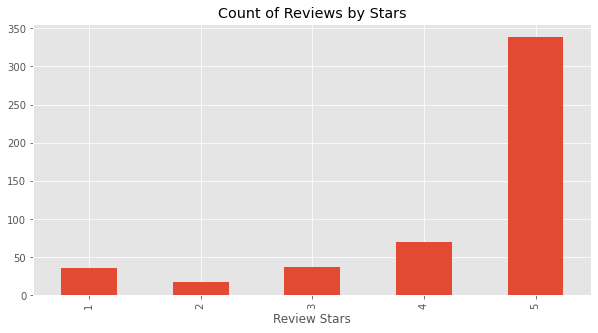

In [99]:
#Exploratory Data Analysis
ax = df['Score'].value_counts().sort_index().plot(kind = 'bar', title = 'Count of Reviews by Stars', figsize = (10,5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [100]:
df.shape
example = df['Text'][100]
print(example)

The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.


In [101]:
#tokenize the sentence above
tokens = nltk.word_tokenize(example)
tokens[:10]

['The', 'mouth', 'says', ',', '``', 'How', 'do', 'I', 'love', 'thee']

In [102]:
#pos tags
tagged = nltk.pos_tag(tokens) #categorizes tokens into their definition as words and context

In [103]:
tagged[:10]

[('The', 'DT'),
 ('mouth', 'NN'),
 ('says', 'VBZ'),
 (',', ','),
 ('``', '``'),
 ('How', 'WRB'),
 ('do', 'VB'),
 ('I', 'PRP'),
 ('love', 'VB'),
 ('thee', 'NN')]

In [104]:
#group the tokens into chunks of text
#entities = nltk.chunk.ne_chunk(tagged)

In [105]:
#entities

## Step 2: VADER Sentiment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.<br>

This will use a bag of words approach.

In [106]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [121]:
sia = SentimentIntensityAnalyzer()

In [108]:
sia.polarity_scores('I am so happy') #neg - negative, neu - neutral, positive - pos, #compoung - aggregation of three

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [109]:
sia.polarity_scores('This is the worst thing ever') #compoung stays more on the negative side, because of its sign

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [110]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'compound': 0.7717}

In [111]:
#Run the polarity score on the entire dataset

result = {}

for i, row in df.iterrows():
    
    myId = row['Id']
    result[myId] = sia.polarity_scores(row['Text'])


In [112]:
vaders = pd.DataFrame(result).T

In [113]:
vaders = vaders.reset_index().rename(columns = {'index':'Id'})

In [114]:
vaders = vaders.merge(df, how = 'left')

In [115]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


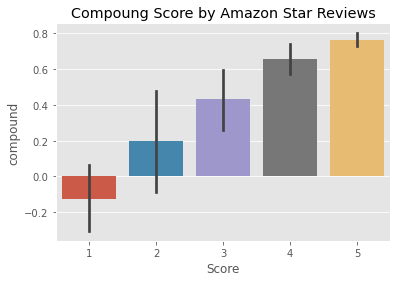

In [116]:
#Plot Vader results
ax = sns.barplot(data = vaders, x = 'Score', y = 'compound')
ax.set_title('Compoung Score by Amazon Star Reviews')
plt.show()

The more positive the compound gets, the higher the review scores will be.

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (12,3))

for i, col in enumerate(vaders.columns[1:4]):
    sns.barplot(data = vaders, x = 'Score', y = col, ax = axs[i])

axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')
plt.tight_layout()

## Roberta Pretrained Model

<ul>
    <li>Use a model trained of a large corpus of data</li>
    <li>Transformer model accounts for the words but also the context related to other words</li>
</ul>

In [5]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')

In [6]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [189]:
#Run for Roberta Model (Encode the sentiment)
encoded_text = tokenizer.encode(example, return_tensors = 'pt')
output = model(encoded_text)

In [190]:
output

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0239,  0.3732, -0.2845]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [191]:
scores = output[0][0].detach().numpy()
scores

array([-0.0239026 ,  0.3732443 , -0.28450698], dtype=float32)

In [195]:
scores = softmax(scores)

In [193]:
scores #negative, neutral and positive

array([0.30692166, 0.45656884, 0.23650949], dtype=float32)

In [32]:
#Storing the scores
score_dict = {'roberta_neg':scores[0],
             'roberta_neu':scores[1],
             'roberta_pos':scores[2]}

In [33]:
score_dict

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687466,
 'roberta_pos': 0.0029573687}

In [43]:
#Run the results in the entire dataset

def polarity_scores_roberta(example):
    
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {'roberta_neg':scores[0],
                   'roberta_neu':scores[1],
                   'roberta_pos':scores[2]}
    
    return scores_dict

In [126]:
result = {}

for i, row in df.iterrows():
    try:
        
        myId = row['Id']
        roberta_results = polarity_scores_roberta(row['Text'])
        vader_results = sia.polarity_scores(row['Text'])
        both = {**vader_results, **roberta_results}
        result[myId] = both
    except RuntimeError:
        print('Broke for id: ',myId)
        

Broke for id:  83
Broke for id:  187


In [127]:
results_df = pd.DataFrame(result).T

In [133]:
results_df = results_df.reset_index().rename(columns = {'index':'Id'})

In [137]:
results_df = results_df.rename(columns = {'neg':'vaders_neg','neu':'vaders_neu','pos':'vaders_pos','compound':'vaders_compoung'})

In [138]:
results_df

,Id,vaders_neg,vaders_neu,vaders_pos,vaders_compoung,roberta_neg,roberta_neu,roberta_pos
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063
...,...,...,...,...,...,...,...,...
493,496,0.000,0.554,0.446,0.9725,0.001906,0.009862,0.988232
494,497,0.059,0.799,0.142,0.7833,0.004415,0.034215,0.961369
495,498,0.025,0.762,0.212,0.9848,0.006427,0.074537,0.919036
496,499,0.041,0.904,0.055,0.1280,0.865614,0.119366,0.015020


In [144]:
results_df = results_df.merge(df, how = 'left')

In [145]:
results_df.columns

Index(['Id', 'vaders_neg', 'vaders_neu', 'vaders_pos', 'vaders_compoung',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Compare Scores between models

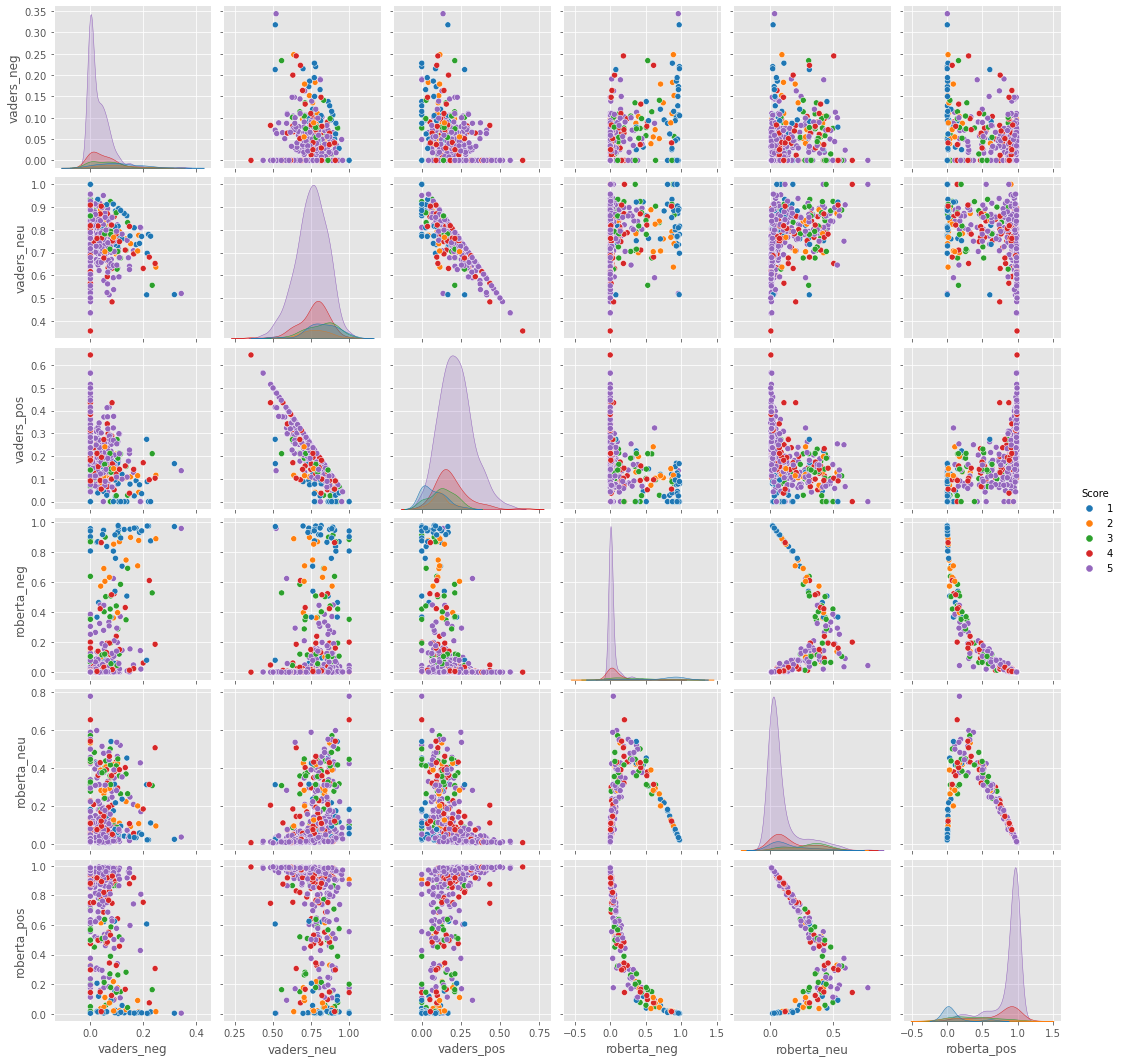

In [146]:
sns.pairplot(data = results_df, vars = ['vaders_neg', 'vaders_neu', 'vaders_pos',
       'roberta_neg', 'roberta_neu', 'roberta_pos'], hue = 'Score', palette = 'tab10')

## Review Examples

Positive 1-star reviews and Negative 5-star reviews

In [154]:
#positive sentiment 1 star review; roberta
results_df[results_df['Score'] == 1].sort_values('roberta_pos', ascending = False)['Text'][252] 

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

It has a positive result, but low review.

In [159]:
#positive sentiment 1 star review; vaders
results_df[results_df['Score'] == 1].sort_values('vaders_pos',ascending=False)['Text'][322] #sarcastic

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [165]:
#negative sentiment 5 star review; roberta
results_df[results_df['Score'] == 5].sort_values('roberta_neg', ascending = False)['Text'][69]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [168]:
#negative sentiment 5 star review; vaders
results_df[results_df['Score'] == 5].sort_values('vaders_neg', ascending = False)['Text'][69]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## The Transformers Pipeline

In [169]:
from transformers import pipeline

In [170]:
sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
